# ML_25M Deep ML

In [35]:
import torch
import time
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from torch.utils.tensorboard import SummaryWriter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# from tab_transformer_pytorch import TabTransformer
# from pytorch_tabnet.tab_model import TabNetClassifier
# from pytorch_tabular import TabularModel
# from pytorch_tabular.models import CategoryEmbeddingModelConfig
# from pytorch_tabular.config import (
#     DataConfig,
#     OptimizerConfig,
#     TrainerConfig,
# )


def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower


fix_random(42)
df = pd.read_csv('dataset.csv')

# PyTorch Device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print('Using device:', device)


Using device: mps


# Data preprocessing

In [38]:
N_LABELS = df.rating.nunique()

X = df.drop('rating', axis=1)
Y = df['rating']

# encode Y
Y = LabelEncoder().fit_transform(Y)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)


# Normalization


# PCA
# pca = PCA(n_components=2)
# pca.fit(X_train)
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)

# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train)
X_train = lda.transform(X_train)
X_val = lda.transform(X_val)
X_test = lda.transform(X_test)

print(f'Number of training samples: {X_train.shape}')
print(f'Number of validation samples: {X_val.shape[0]}')
print(f'Number of testing samples: {X_test.shape}')

# train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.long)), batch_size=batch, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(Y_val, dtype=torch.long)), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.long)), batch_size=64, shuffle=True)

results = pd.DataFrame(columns=['Model', 'Accuracy'])

Number of training samples: (9946, 9)
Number of validation samples: 1106
Number of testing samples: (2764, 9)


In [39]:
# Effective Number of Samples
def get_weights_effective_num_of_samples(no_of_classes, beta, samples_per_cls):
    effective_num = 1.0 - np.power(beta, samples_per_cls)
    class_weights = (1.0 - beta) / np.array(effective_num)
    class_weights = class_weights / np.sum(class_weights)*no_of_classes
    return {i: w for i, w in enumerate(class_weights)}

weights = get_weights_effective_num_of_samples(N_LABELS, 0.999, np.bincount(Y_train))


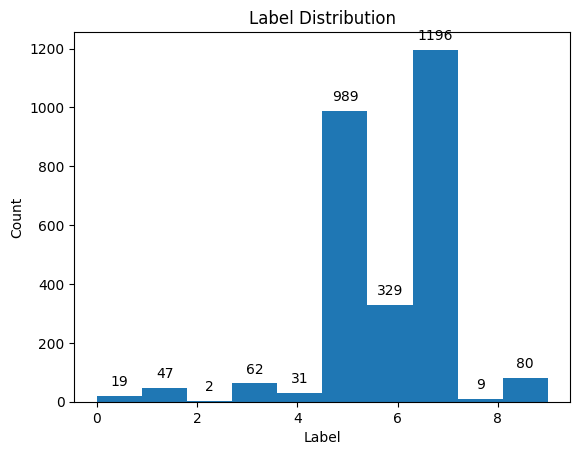

In [41]:
# test label distribution
plt.hist(Y_test )
plt.title('Label Distribution')
for p in plt.gca().patches:
    plt.gca().annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2.,
                                                         p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xlabel('Label')
plt.ylabel('Count')
plt.show()




# Neural Network

In [42]:
def get_nn_model(input_size, hidden_size, num_classes, dropout_prob=0, depth=1):
    model = [
        torch.nn.Linear(input_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Dropout(dropout_prob)
    ]

    for i in range(depth):
        model.append(torch.nn.Linear(hidden_size, hidden_size))
        model.append(torch.nn.ReLU())
        model.append(torch.nn.Dropout(dropout_prob))

    model.append(torch.nn.Linear(hidden_size, num_classes))
    model.append(torch.nn.Softmax(dim=1))

    return torch.nn.Sequential(*model)


In [76]:
# hyperparameters
hidden_sizes = [64, 128, 256]
nums_epochs = [100]
depth = [3, 4]
batch_sizes = [16, 32, 64, 128]
learning_rate = [0.01]
step_size_lr_decay = [10, 25, 50]
dropout_prob = 0.2
patience = 10

hyperparameters = itertools.product(hidden_sizes, depth, nums_epochs, batch_sizes, learning_rate, step_size_lr_decay)
print (f'Number of hyperparameter combinations: {len(hidden_sizes)*len(depth)*len(nums_epochs)*len(batch_sizes)*len(learning_rate)*len(step_size_lr_decay)}')

Number of hyperparameter combinations: 72


In [44]:
# training process
def train_model(model, criterion, optimizer, scheduler, epochs, data_loader, val_loader, device, writer):
    n_iter = 0

    best_val_loss = float('inf')
    epochs_since_last_improvement = 0

    start = time.time()

    for epoch in range(epochs):
        model.train()

        start_epoch = time.time()

        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()

            # Forward pass
            y_pred = model(data)

            # Compute Loss
            loss = criterion(y_pred, targets)
            writer.add_scalar("Loss/train", loss, n_iter)

            # Backward pass
            loss.backward()
            optimizer.step()

            n_iter += 1

        scheduler.step()

        # Compute Val Loss
        labels, _, y_pred = test_model(model, val_loader, device)
        val_loss = criterion(y_pred, labels)
        writer.add_scalar("Loss/val", val_loss, epoch)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'models/best_model.pth')
            epochs_since_last_improvement = 0
        else:
            epochs_since_last_improvement += 1

        if epochs_since_last_improvement >= patience:
            break

        print('Epoch [{}/{}] - {:.2f} seconds - loss: {:.4f} - val_loss: {:.4f} - patience: {}'.format(epoch+1,
              epochs, time.time() - start_epoch, loss.item(), val_loss.item(), epochs_since_last_improvement), end='\r')

    print('\nTraining ended after {:.2f} seconds'.format(time.time() - start))

    # Restore best model
    model.load_state_dict(torch.load('models/best_model.pth'))
    return model

# evaluation process
def test_model(model, data_loader, device):
    model.eval()
    y_pred = []
    y_test = []

    with torch.no_grad():
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)

            y_pred.append(model(data))
            y_test.append(targets)

    y_pred = torch.cat(y_pred, dim=0)
    y_test = torch.cat(y_test, dim=0)

    y_pred_c = torch.argmax(y_pred, dim=1)

    return y_test, y_pred_c, y_pred


In [79]:
best_acc = 0
best_model = None

if os.path.exists('best_model.pth'):
    # read best model config
    with open('best_model_config.json', 'r') as f:
        best_model_config = json.load(f)

    # load best model
    best_model = get_nn_model(X_train.shape[1], best_model_config['hidden_size'], N_LABELS, dropout_prob, best_model_config['depth'])
    best_model.load_state_dict(torch.load('best_model.pth'))
    best_model.to(device)
    best_model.eval()

    # evaluate best model
    y_test, y_pred_c, y_pred = test_model(best_model, test_loader, device)
    metrics = classification_report(y_test.cpu(), y_pred_c.cpu(), output_dict=True, zero_division=0)
    best_acc = metrics['accuracy']*100
    
print("Best model accuracy so far: {:.2f}%".format(best_acc))

for hidden_size, depth, num_epochs, batch, lr, step_size in hyperparameters:
    
    if not os.path.exists('models'):
        os.makedirs('models')

    print("\nTraining with hidden_size={}, depth={}, num_epochs={}, batch={}, lr={}, step_size={}".format(
        hidden_size, depth, num_epochs, batch, lr, step_size))
    log_name = "dim:"+str(hidden_size)+"_depth:"+str(depth)+"_epochs:"+str(num_epochs)+"_batch:" + \
        str(batch)+"_lr:"+str(lr)+"_step_size:" + \
        str(step_size)

    if os.path.exists('runs/'+log_name):
        print("Model already trained, skipping...")
        continue

    # start tensorboard
    writer = SummaryWriter('runs/'+log_name)

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(
        X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.long)), batch_size=batch, shuffle=True)

    model = get_nn_model(X_train.shape[1], hidden_size, N_LABELS, dropout_prob, depth=depth)
    model.to(device)

    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(weights.values()), dtype=torch.float32).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

    # train
    model = train_model(model, criterion, optimizer, scheduler,
                        num_epochs, train_loader, val_loader, device, writer)

    # validate
    y_test, y_pred_c, y_pred = test_model(model, test_loader, device)

    metrics = classification_report(y_test.cpu(), y_pred_c.cpu(), output_dict=True, zero_division=0)
    writer.add_scalar('metrics/test accuracy', metrics['accuracy'])

    writer.add_hparams({'hidden_size': hidden_size, 'depth': depth, 'num_epochs': num_epochs, 'batch': batch,'lr': lr, 'step_size': step_size, 'momentum': momentum}, {'hparam/accuracy': metrics['accuracy']})

    if metrics['accuracy']*100 > best_acc:
        best_acc = metrics['accuracy']*100
        best_model = model
        torch.save(model.state_dict(), 'best_model.pth')
        # save config
        with open('best_model_config.json', 'w') as f:
            json.dump({'hidden_size': hidden_size, 'depth': depth, 'num_epochs': num_epochs, 'batch': batch,
                       'lr': lr, 'step_size': step_size}, f)
            
            
    print("Model accuracy: {:.2f}%".format(metrics['accuracy']))
    print("Best accuracy so far: {:.2f}".format(best_acc))

    torch.save(model.state_dict(), 'models/'+log_name+'.pth')
    writer.flush()

writer.close()



Best model accuracy so far: 72.25%

Training with hidden_size=64, depth=3, num_epochs=100, batch=64, lr=0.01, step_size=25
Epoch [13/100] - 1.40 seconds - loss: 1.7029 - val_loss: 2.0739 - patience: 9
Training ended after 20.05 seconds
Model accuracy: 0.70%
Best accuracy so far: 72.25

Training with hidden_size=64, depth=3, num_epochs=100, batch=64, lr=0.01, step_size=50
Epoch [10/100] - 1.57 seconds - loss: 1.9983 - val_loss: 2.0646 - patience: 9
Training ended after 16.14 seconds
Model accuracy: 0.71%
Best accuracy so far: 72.25

Training with hidden_size=64, depth=3, num_epochs=100, batch=128, lr=0.01, step_size=10
Epoch [15/100] - 0.71 seconds - loss: 2.1978 - val_loss: 2.0548 - patience: 9
Training ended after 12.29 seconds
Model accuracy: 0.71%
Best accuracy so far: 72.25

Training with hidden_size=64, depth=3, num_epochs=100, batch=128, lr=0.01, step_size=25
Epoch [10/100] - 0.72 seconds - loss: 2.0795 - val_loss: 2.0605 - patience: 9
Training ended after 7.97 seconds
Model accu

KeyboardInterrupt: 

In [ ]:
# test
best_model.eval()
y_test, y_pred_c, y_pred = test_model(best_model, test_loader, device)
print(classification_report(y_test.cpu(), y_pred_c.cpu()))
accuracy = accuracy_score(y_test.cpu(), y_pred_c.cpu())

results = pd.concat([results, pd.DataFrame({'Model': 'NeuralNetwork', 'Accuracy': accuracy}, index=[0])], ignore_index=True)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        80
           3       0.55      0.63      0.59       284
           4       0.78      0.69      0.73       804
           5       0.72      0.93      0.81      1159
           6       0.84      0.46      0.59       426
           7       0.00      0.00      0.00         1

    accuracy                           0.72      2764
   macro avg       0.36      0.34      0.34      2764
weighted avg       0.71      0.72      0.70      2764



/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

# Transformer